## Anomaly Detection- windowed method 

In [1]:
import numpy as np
import pandas as pd
import pickle
import keras
from keras import layers
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.layers import Lambda, Input, Dense, Dropout
from utils.functions import sample, create_sequences, get_error_term
from model.vae_window import vae_window

Importing the dataset

In [2]:
data = pd.read_csv("data/realTweets/realTweets/Twitter_volume_CRM.csv",
                   parse_dates=True, index_col="timestamp")
data

,value
timestamp,
2015-02-26 21:42:53,11
2015-02-26 21:47:53,10
2015-02-26 21:52:53,3
2015-02-26 21:57:53,4
2015-02-26 22:02:53,9
...,...
2015-04-23 02:27:53,1
2015-04-23 02:32:53,4
2015-04-23 02:37:53,3


In [3]:
with open('lists.pkl', 'rb') as f:
    lists = pickle.load(f)

# Access the lists
instances_of_anomaly= lists[1]

In [4]:
data_with_anomaly = data.copy()
data_with_anomaly['anomaly'] = 0
for instance in instances_of_anomaly: 
    start = pd.to_datetime(instance[0])
    end = pd.to_datetime(instance[1])
    data_with_anomaly.loc[(data_with_anomaly.index >= start) & (data_with_anomaly.index <= end), 'anomaly'] = 1

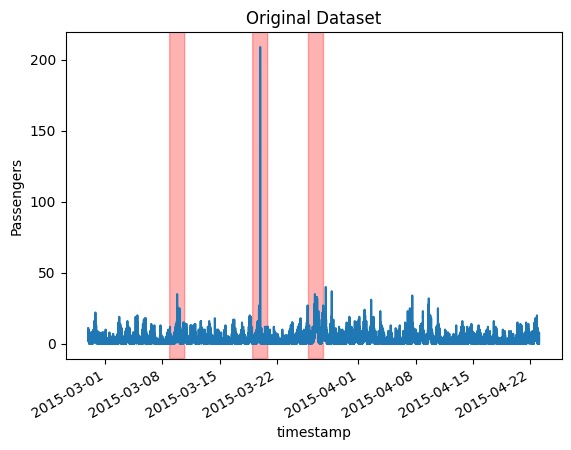

In [5]:
fig, ax = plt.subplots()
data.plot(legend=False, ax=ax)
ax.fill_between(data_with_anomaly.index, 0, 1, where=data_with_anomaly['anomaly'], color='red', alpha=0.3, transform=ax.get_xaxis_transform(), label='Real anomaly')
plt.ylabel("Passengers")
plt.title("Original Dataset")
plt.show()

Splitting training and testing: First 60% for test, last 40% for train

In [6]:
# Splitting to train and test
test_ratio =0.6
tr_data = data.iloc[int(len(data) * test_ratio) :]
tst_data = data.iloc[: int(len(data) * test_ratio)]
data_with_anomaly= data_with_anomaly.iloc[: int(len(data) * test_ratio)]

In [7]:
tr_data

,value
timestamp,
2015-04-01 00:47:53,3
2015-04-01 00:52:53,4
2015-04-01 00:57:53,1
2015-04-01 01:02:53,4
2015-04-01 01:07:53,6
...,...
2015-04-23 02:27:53,1
2015-04-23 02:32:53,4
2015-04-23 02:37:53,3


Normailzing the training set 

In [8]:
# Normalize and save the mean and std we get, for normalizing test data.
training_mean = tr_data.mean()
training_std = tr_data.std()
train_scaled = (tr_data - training_mean) / training_std
print("Number of training samples:", len(train_scaled))

Number of training samples: 6361


Each sample is five minutes apart, so 288 samples accounts for a day

In [9]:
step_size = 288

train = create_sequences(train_scaled.values, step_size)
print("Training input shape: ", train.shape)

Training input shape:  (6074, 288, 1)


VAE model

In [10]:
vae = vae_window(train, latent_dim=8)
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 288, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 144, 32)   │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 144, 32)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 72, 16)    │      3,600 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 8),       │     22,304 │ input_layer[0][0] │
│ (Functional)        │ (None, 8), (None, │            │                   │
│                     │ 8)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1152)      │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 288, 1)    │     59,553 │ encoder[0][2]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 8)         │      9,224 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 8)         │      9,224 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer      │ (None, 288, 1)    │          0 │ input_layer[0][0… │
│ (VAELossLayer)      │                   │            │ decoder[0][0],    │
│                     │                   │            │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 81,857 (319.75 KB)

 Trainable params: 81,857 (319.75 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# history = vae.fit(
#     train,
#     train,
#     epochs=50,
#     batch_size=256,
#     validation_split=0.2,
#     callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)])

In [12]:
from sklearn.model_selection import KFold

# Define the number of folds
n_folds = 8

# Create a KFold object
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=1)

# Initialize a list to hold the history objects returned by the fit method
histories = []

# Loop over the indices returned by kfold.split
for train_index, val_index in kfold.split(train):
    # Generate the training and validation datasets
    train_fold = train[train_index]
    val_fold = train[val_index]

    # Fit the model and append the history object to the list
    history = vae.fit(
        train_fold,
        train_fold,
        epochs=50,
        batch_size=256,
        validation_data=(val_fold, val_fold),
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)]
    )
    histories.append(history)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 70821.8750 - val_loss: 67394.7422
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 59010.0391 - val_loss: 43754.7227
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 43262.1523 - val_loss: 42102.3633
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 41588.2578 - val_loss: 40737.4102
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 40557.0859 - val_loss: 39638.4297
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 39616.1797 - val_loss: 38629.1992
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 38080.9766 - val_loss: 38042.2461
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 37831.9453 - val_loss: 37464.9727
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 37654.3750 - val_loss: 36988.7969
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 36635.8516 - val_loss: 36585.6367
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 36798.156

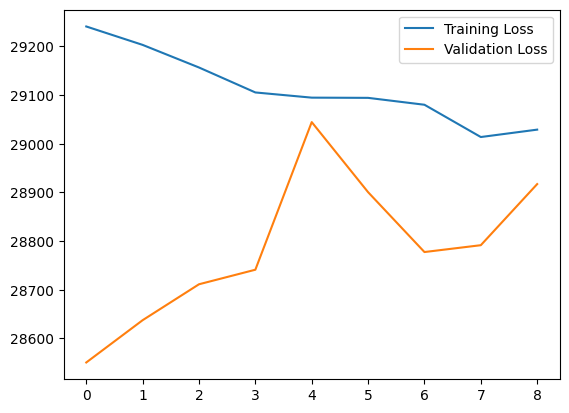

In [13]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(6074, 1)


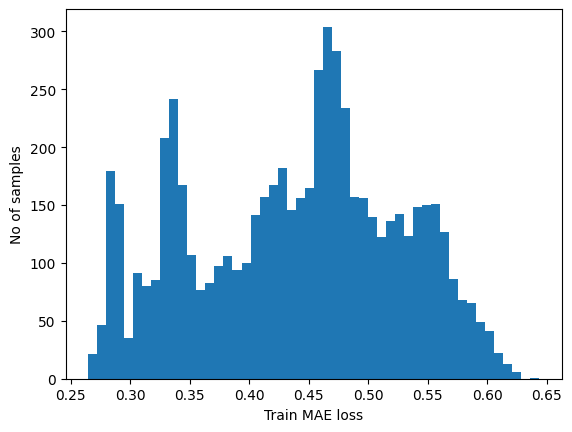

Reconstruction error threshold:  0.6435150519733153


In [14]:
# Get train MAE loss.
train_pred = vae.predict(train)[0]
train_mae_loss = np.mean(np.abs(train_pred - train), axis=1)
print(train_mae_loss.shape)
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

In [15]:
print(train_pred.shape)

(6074, 288, 1)


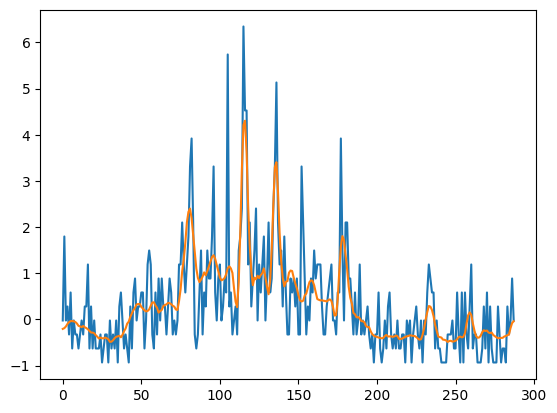

In [16]:
# Checking how the first sequence is learnt
plt.plot(train[90])
plt.plot(train_pred[90])
plt.show()

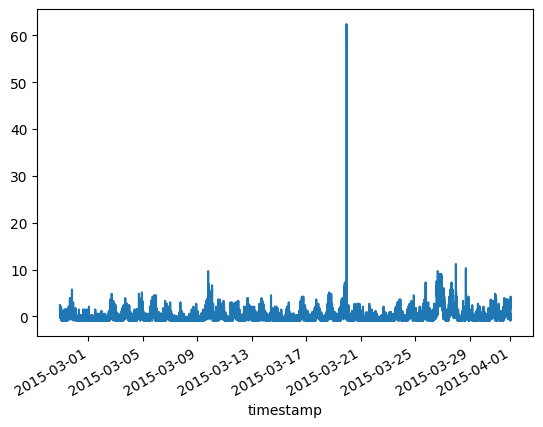

Test input shape:  (9254, 288, 1)
290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
(9254, 1)


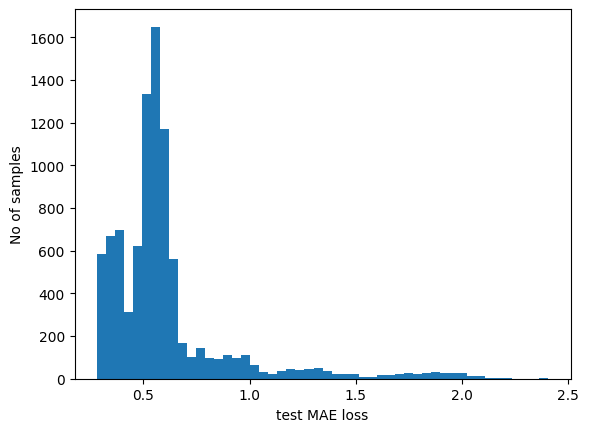

Number of anomaly samples:  1855
Indices of anomaly samples:  (array([  74,   76,   77, ..., 9251, 9252, 9253], dtype=int64), array([0, 0, 0, ..., 0, 0, 0], dtype=int64))


In [17]:

test_scaled = (tst_data - training_mean) / training_std
fig, ax = plt.subplots()
test_scaled.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
test = create_sequences(test_scaled.values, step_size)
print("Test input shape: ", test.shape)

# Get test MAE loss.
test_pred = vae.predict(test)[0]
test_mae_loss = np.mean(np.abs(test_pred - test), axis=1)
print(test_mae_loss.shape)
#test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [18]:
anomalous_data_indices = []
for ind in range(len(anomalies)):
    if anomalies[ind]:
        anomalous_data_indices.append(ind)

In [19]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(step_size - 1, len(test_scaled) - step_size + 1):
    if np.all(anomalies[data_idx - step_size + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

In [20]:
# # data i is an anomaly if more than 90% of samples [(i - timesteps + 1) to (i)] are anomalies
# step_size = 288
# anomalous_data_indices = []
# for data_idx in range(step_size - 1, len(test_scaled) - step_size + 1):
#     if np.sum(anomalies[data_idx - step_size + 1 : data_idx]) > step_size * 0.9:
#         anomalous_data_indices.append(data_idx)

In [21]:
print("Indices of anomalies: ", anomalous_data_indices)

Indices of anomalies:  [3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152, 3153, 3154, 3155, 3156, 3157, 3158, 3159, 3160, 3161, 3162, 3163, 3164, 3165, 3166, 3167, 3168, 3169, 3170, 3171, 3172, 3173, 3174, 3175, 3176, 3177, 3178, 3179, 3180, 3181, 3182, 3183, 3184, 3185, 3186, 3187, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196, 3197, 3198, 3199, 3200, 3201, 3202, 3203, 3204, 3205, 3206, 3207, 3208, 3209, 3210, 3211, 3212, 3213, 3214, 3215, 3216, 3217, 3218, 6030, 6031, 6032, 6033, 6034, 6035, 6036, 6037, 6038, 6039, 6040, 6041, 6042, 6043, 6044, 6045, 6046, 6047, 6048, 6049, 6050, 6051, 6052, 6053, 6054, 6055, 6056, 6057, 6058, 6059, 6060, 6061, 6062, 6063, 6064, 6065, 6066, 6067, 6068, 6069, 7954, 7955, 7956, 7957, 7958, 7959, 7960, 7961, 7962, 7963, 7964, 7965, 7966, 7967, 7968, 7969, 7970, 7971, 7972, 7973, 7974, 7975, 7976, 7977, 7978, 7979, 7980, 7981, 7982, 7983, 7984, 7985, 7986, 7987, 7988, 7989, 7990, 7991, 7992, 7993, 7994, 7995, 7996, 7997, 7998, 7999, 8000, 8001, 8002

In [22]:
df_subset = tst_data.iloc[anomalous_data_indices]
df_subset

,value
timestamp,
2015-03-09 19:47:53,10
2015-03-09 19:52:53,12
2015-03-09 19:57:53,6
2015-03-09 20:02:53,11
2015-03-09 20:07:53,18
...,...
2015-03-28 00:32:53,10
2015-03-28 00:37:53,13
2015-03-28 00:42:53,10


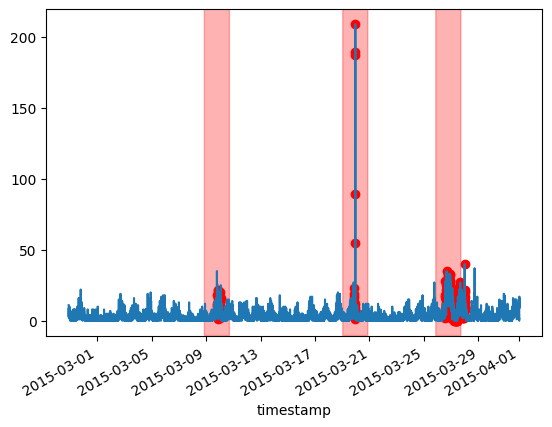

In [23]:
fig, ax = plt.subplots()
tst_data.plot(legend=False, ax=ax)
ax.fill_between(data_with_anomaly.index, 0, 1, where=data_with_anomaly['anomaly'], color='red', alpha=0.3, transform=ax.get_xaxis_transform(), label='Real anomaly')
ax.scatter(df_subset.index, df_subset['value'], color="r")
plt.show()